Best validation RMSE: 0.4986580399284537
Best hyperparameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.03}
Rolling Forecast Test Metrics: {'MSE': 1.2300979496741458, 'RMSE': 1.1090978088852874, 'MAE': 0.7542166582322284, 'MAPE%': np.float64(1.176685079491749), 'R2': 0.9650052556073269}


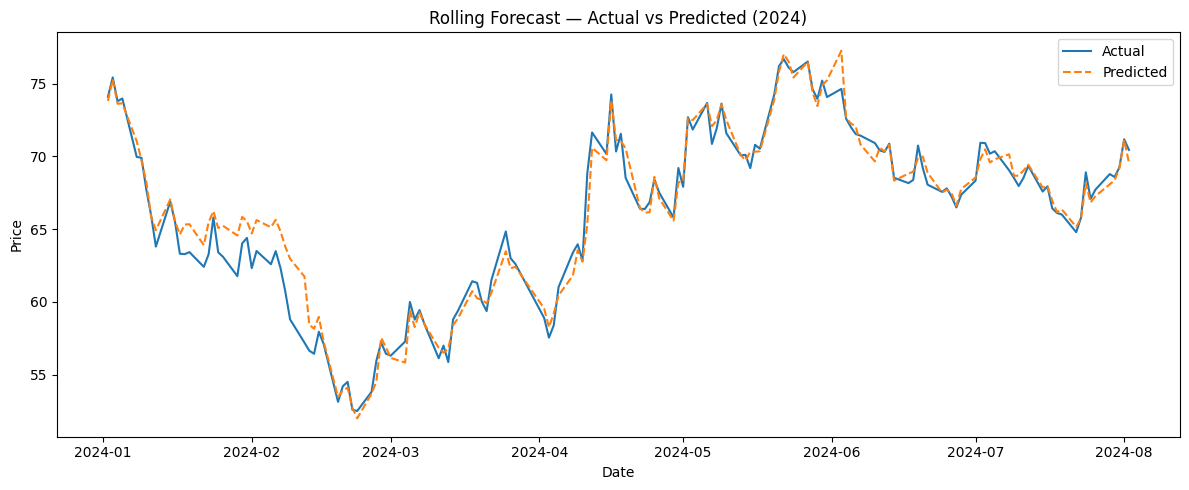

In [14]:
"""
Modified: Carbon Price Forecasting with XGBoost — Rolling Forecast on Test Set
- Keeps training/validation process the same
- Test set predictions are now done recursively (rolling), using previous predicted values for lag/rolling features
"""

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

RANDOM_STATE = 42
CSV_PATH = "Carbon_Emissions_Futures_2021_Onwards.csv"
DATE_COL = "Date"
TARGET_COL = "Price"
LAG_STEPS = [1, 2, 3, 4, 5]
ROLL_WINDOWS = [3, 7, 15, 30]

def _parse_volume(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float)):
        return float(v)
    s = str(v).strip().replace(",", "")
    if s.endswith(('K','k')):
        return float(s[:-1]) * 1_000
    if s.endswith(('M','m')):
        return float(s[:-1]) * 1_000_000
    return float(s)

def clean_dataframe(df):
    df = df.copy()
    df.rename(columns={"Vol.": "Volume", "Change %": "ChangePct"}, inplace=True)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True, errors='coerce')
    for col in ["Price", "Open", "High", "Low"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df["Volume"] = df["Volume"].apply(_parse_volume)
    df["ChangePct"] = pd.to_numeric(df["ChangePct"].astype(str).str.replace('%',''), errors='coerce') / 100.0
    return df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)

def add_features(df):
    for lag in LAG_STEPS:
        df[f"Price_lag{lag}"] = df[TARGET_COL].shift(lag)
    for w in ROLL_WINDOWS:
        df[f"Price_roll_mean_{w}"] = df[TARGET_COL].rolling(w).mean()
        df[f"Price_roll_std_{w}"] = df[TARGET_COL].rolling(w).std()
    df["HL_range"] = (df["High"] - df["Low"]) / df["Open"].replace(0, np.nan)
    return df

def train_val_test_split(df):
    train_mask = (df[DATE_COL] >= '2021-01-01') & (df[DATE_COL] <= '2023-12-31')
    test_mask = (df[DATE_COL] >= '2024-01-01') & (df[DATE_COL] <= '2024-12-31')
    df_train_full = df.loc[train_mask].copy()
    df_test = df.loc[test_mask].copy()
    split_idx = int(len(df_train_full) * 0.9)
    return df_train_full.iloc[:split_idx], df_train_full.iloc[split_idx:], df_test

def select_features(df):
    base = ["Open", "High", "Low", "Volume", "ChangePct", "HL_range"]
    return [c for c in base if c in df.columns] + [c for c in df.columns if c.startswith("Price_lag") or c.startswith("Price_roll_")]

def scale_fit_transform(train_X, val_X=None):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(train_X)
    Xval = scaler.transform(val_X) if val_X is not None else None
    return Xtr, Xval, scaler

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2_score(y_true, y_pred)}

if __name__ == "__main__":
    df = clean_dataframe(pd.read_csv(CSV_PATH))
    df = add_features(df).dropna().reset_index(drop=True)
    df_train, df_val, df_test = train_val_test_split(df)
    features = select_features(df)

    X_train, y_train = df_train[features], df_train[TARGET_COL].values
    X_val, y_val = df_val[features], df_val[TARGET_COL].values
    Xtr_scaled, Xval_scaled, scaler_tr = scale_fit_transform(X_train, X_val)

    param_grid = [{"n_estimators": n, "max_depth": d, "learning_rate": lr} for n in [200, 300, 400, 500, 600] for d in [3,5] for lr in [0.03,0.01]]
    best_params, best_rmse = None, float('inf')
    for params in param_grid:
        model = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, **params)
        model.fit(Xtr_scaled, y_train)
        rmse = math.sqrt(mean_squared_error(y_val, model.predict(Xval_scaled)))
        if rmse < best_rmse:
            best_rmse, best_params = rmse, params

    # Best model evaluation
    print("Best validation RMSE:", best_rmse)
    print("Best hyperparameters:", best_params)

    df_train_full = pd.concat([df_train, df_val])
    X_train_full, y_train_full = df_train_full[features], df_train_full[TARGET_COL].values
    scaler_full = StandardScaler().fit(X_train_full)
    model_final = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, **best_params)
    model_final.fit(scaler_full.transform(X_train_full), y_train_full)

    df_test_copy = df_test.copy()
    preds = []
    history_df = pd.concat([df_train_full, df_test_copy.iloc[0:0]])

    for i in range(len(df_test_copy)):
        current_row = df_test_copy.iloc[[i]].copy()
        hist_prices = history_df[TARGET_COL].tolist()
        for lag in LAG_STEPS:
            current_row[f"Price_lag{lag}"] = hist_prices[-lag]
        for w in ROLL_WINDOWS:
            current_row[f"Price_roll_mean_{w}"] = pd.Series(hist_prices).rolling(w).mean().iloc[-1]
            current_row[f"Price_roll_std_{w}"] = pd.Series(hist_prices).rolling(w).std().iloc[-1]
        X_curr = current_row[features]
        pred = model_final.predict(scaler_full.transform(X_curr))[0]
        preds.append(pred)
        history_df = pd.concat([history_df, pd.DataFrame({DATE_COL: current_row[DATE_COL].values, TARGET_COL: [pred]})], ignore_index=True)

    metrics = evaluate(df_test_copy[TARGET_COL].values, np.array(preds))
    print("Rolling Forecast Test Metrics:", metrics)

    plt.figure(figsize=(12,5))
    plt.plot(df_test_copy[DATE_COL], df_test_copy[TARGET_COL], label='Actual')
    plt.plot(df_test_copy[DATE_COL], preds, label='Predicted', linestyle='--')
    plt.title('Rolling Forecast — Actual vs Predicted (2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
